In [1]:
from datetime import date
from glob import glob
import json
import os
from pathlib import Path
import pickle
import sys
import time

from matplotlib.colorbar import Colorbar
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import mplcursors
import numpy as np
import pandas as pd
from scipy import interpolate, signal, stats, fftpack, ndimage

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import get_evoked_traces, get_events_wdict, find_nearest_ind

In [4]:
%matplotlib widget

# Load experimental subjects

In [5]:
subject_csv = Path(r"C:\Users\lesliec\OneDrive - Allen Institute\analysis\GAT1-KO_analyses\GAT1_control_NPephys_subjects.csv")
all_subexp = pd.read_csv(subject_csv, converters={'mouse': str})
all_subexp.head()

,genotype,mouse,experiment,drug,inj_time,sweep_states,bad_chs,CCFres,NPX_analysis,EEG_analysis,skull_screws,NPX_ref,EEG_ref,shared_ref_gnd,data_loc,notes
0,GAT1-KO,645606,EEGNPXspont_estim_2022-12-20_12-26-39,none,0,awake,none,25,True,True,2.0,Neuropixels tip reference electrode,NaN,NaN,E:\GAT1_EEG_pilot\mouse645606\EEGNPXspont_esti...,100um offset stim electrode
1,GAT1-KO,644565,EEGNPXspont_estim_2022-12-22_10-36-08,none,0,awake,none,25,True,True,2.0,Neuropixels tip reference electrode,NaN,NaN,E:\GAT1_EEG_pilot\mouse644565\EEGNPXspont_esti...,"100um offset stim electrode, probeB LFP estim ..."
2,GAT1-KO,672785,EEGNPXspont_estim_2023-07-05_12-39-59,none,0,awake,all,25,True,False,2.0,Neuropixels tip reference electrode,"stainless steel skull screw, left CB","separate ref, shared gnd",E:\GAT1_EEG_pilot\mouse672785\EEGNPXspont_esti...,EEG has low amplitude signals and all chs look...
3,GAT1-KO,672789,EEGNPXspont_estim_2023-07-13_13-28-01,none,0,awake,none,25,True,True,2.0,"stainless steel skull screw, right CB","stainless steel skull screw, left CB","separate ref, shared gnd",E:\GAT1_EEG_pilot\mouse672789\EEGNPXspont_esti...,NaN
4,wildtype,654181,estim_vis_2022-11-22_09-42-58,isoflurane,0,"awake,isoflurane","7,8,11,13",25,True,True,NaN,NaN,NaN,NaN,F:\psi_exp\mouse654181\estim_vis_2022-11-22_09...,good control mouse with RT units


# Test one session

In [6]:
choose_sub = 0
exprow = all_subexp.iloc[choose_sub]
exp = EEGexp(exprow.data_loc, preprocess=False, make_stim_csv=False)

Experiment type: electrical stimulation


In [7]:
if exprow.NPX_analysis:
    print('Yes, this experiment has good NPX data.')
else:
    print('This experiment does NOT have good NPX data, skip it.')

Yes, this experiment has good NPX data.


In [8]:
plotsavedir = os.path.join(r'C:\Users\lesliec\OneDrive - Allen Institute\analysis\GAT1-KO_analyses', 'mouse' + exp.mouse)
if not os.path.exists(plotsavedir):
    os.mkdir(plotsavedir)

exp_tag = exp.experiment_folder[exp.experiment_folder.find('mouse')+12:exp.experiment_folder.find(str(exp.date.year))-1]
print(exp_tag)

EEGNPXspont_estim


In [9]:
stim_elec_file = os.path.join(exp.data_folder, r'stim_elec_location.json')
if os.path.exists(stim_elec_file):
    with open(stim_elec_file) as elec_file:
        stim_elec_data = json.load(elec_file)
    print(stim_elec_data)
else:
    print('Stim electrode location file not found.')

{'surface': {'area': 'MOs1', 'ccf_coords': [148, 61, 150]}, 'tip': {'area': 'ccg', 'ccf_coords': [176, 116, 163]}}


In [10]:
stim_elec_data['tip']['area']

'ccg'

## Load experimental data

### Load stim log

In [11]:
if exp.stimulus_log_file:
    stim_log = pd.read_csv(exp.stimulus_log_file).astype({'parameter': str})
else:
    print('No stim log found.')

In [12]:
stim_log.head()

,stim_type,parameter,duration,onset,offset,sweep,mean_speed,resting_trial,SWD,good
0,biphasic,50,0.0004,3004.42943,3004.42983,0,10.281199,False,True,True
1,biphasic,50,0.0004,3025.43502,3025.43542,0,5.057074,False,True,True
2,biphasic,50,0.0004,3044.45591,3044.45631,0,0.000000,True,True,True
3,biphasic,50,0.0004,3064.48025,3064.48065,0,0.432813,False,True,True
4,biphasic,50,0.0004,3085.27708,3085.27748,0,4.700194,False,False,True


### Load manual annotation of event in SWD

In [13]:
EEGSWDfile = os.path.join(exp.data_folder, r'EP_in_SWD.npy')
EEG_SWD = np.load(EEGSWDfile).astype(bool)

stimSWDfile = os.path.join(exp.data_folder, r'EP_in_SWD_LFP.npy')
LFP_SWD_tfa = np.load(stimSWDfile)

stimSWDboolfile = os.path.join(exp.data_folder, r'EP_in_SWD_LFP_TF.npy')
LFP_SWD_tf = np.load(stimSWDboolfile).astype(bool)

In [14]:
print('SWDs classified in EEG: {:d}'.format(np.sum(EEG_SWD)))
print('SWDs classified in LFP (tfa): {:d}'.format(np.sum(LFP_SWD_tfa == 't')))
print('SWDs classified in LFP (T/F): {:d}'.format(np.sum(LFP_SWD_tf)))

SWDs classified in EEG: 40
SWDs classified in LFP (tfa): 28
SWDs classified in LFP (T/F): 33


In [15]:
print(EEG_SWD[:10])
print(LFP_SWD_tfa[:10])
print(LFP_SWD_tf[:10])

[False False False  True False False  True  True False  True]
['f' 'f' 'f' 'f' 'f' 'f' 't' 't' 'f' 't']
[False False False False False False  True  True False  True]


### Load SWD events

### Load running speed

## Load LFP

### Get probe list

In [16]:
probe_list = [x.replace('_sorted', '') for x in exp.experiment_data if 'probe' in x]
print(probe_list)

['probeB', 'probeC', 'probeF']


In [17]:
for probei in probe_list:
    print(probei)
    with open(exp.ephys_params[probei]['probe_info']) as data_file:
        data = json.load(data_file)
    probe_areas = np.array(data['area_ch'])
    print(np.unique(probe_areas))
    print('')

probeB
['CA1' 'CA2' 'CA3' 'LD' 'SSp-ll6a' 'SSp-ll6b' 'SSp-tr1' 'SSp-tr2/3'
 'SSp-tr4' 'SSp-tr5' 'SSp-tr6a' 'VAL' 'alv' 'ccb' 'cing' 'null' 'root']

probeC
['CA3' 'RT' 'SSp-bfd2/3' 'SSp-bfd4' 'SSp-bfd5' 'SSp-bfd6a' 'SSp-bfd6b'
 'VISrl1' 'VISrl2/3' 'alv' 'ccb' 'ccs' 'chpl' 'fi' 'fiber tracts' 'int'
 'null' 'or' 'st']

probeF
['BST' 'CP' 'MOp1' 'MOp2/3' 'MOp5' 'MOp6a' 'MOp6b' 'PAL' 'STR' 'ccb'
 'null' 'scwm']



### Choose probe to plot

In [18]:
probe_name = 'probeB'

## Load LFP as memmap ##
# lfp_ts = np.load(exp.ephys_params[probe_name]['lfp_timestamps'])
# lfp_data_mm = np.memmap(exp.ephys_params[probe_name]['lfp_continuous'], dtype='int16', mode='r').reshape(
#     (len(lfp_ts), exp.ephys_params[probe_name]['num_chs']))

## Load probe_info.json ##
with open(exp.ephys_params[probe_name]['probe_info']) as data_file:
    data = json.load(data_file)
npx_allch = np.array(data['channel'])
surface_ch = int(data['surface_channel'])
allch_z = np.array(data['vertical_pos'])
ref_mask = np.array(data['mask'])
npx_chs = np.array([x for x in npx_allch if ref_mask[x] and x <= surface_ch])
probe_ch_depths = allch_z[surface_ch] - allch_z
probe_areas = np.array(data['area_ch'])

In [19]:
area_choice = 'SSp' # 'SSp', 'MOp'
area_mask = np.array([area_choice in x for x in probe_areas])

#### Load a single channel

In [20]:
## Load LFP as memmap ##
lfp_ts = np.load(exp.ephys_params[probe_name]['lfp_timestamps'])
lfp_data_mm = np.memmap(exp.ephys_params[probe_name]['lfp_continuous'], dtype='int16', mode='r').reshape(
    (len(lfp_ts), exp.ephys_params[probe_name]['num_chs']))

In [21]:
lfp_raw_chs = lfp_data_mm[:, area_mask] # * exp.ephys_params[probe_name]['bit_volts']
print(lfp_raw_chs.shape)

(10962185, 126)


Get event traces

In [22]:
event_window = [-2.0, 2.0]
plot_events = stim_log[stim_log['stim_type'] == 'biphasic']
event_LFPchs, event_ts = get_evoked_traces(
    lfp_raw_chs, lfp_ts, plot_events.onset.values, -event_window[0], event_window[1], exp.ephys_params[probe_name]['lfp_sample_rate']
)
print(event_LFPchs.shape)

(10000, 126, 60)


In [23]:
check_window = [-0.05, 0.5]
checkinds = np.squeeze(np.argwhere((event_ts >= check_window[0]) & (event_ts <= check_window[1])))

num_samples = []
for chi, max_val in enumerate(np.max(np.max(event_LFPchs[checkinds,:,:], axis=2), axis=0)):
    num_samples.append(np.sum(event_LFPchs[checkinds,chi,:] > (max_val - 500), axis=0))
num_samples_all_trials = np.array(num_samples)

sample_thresh = 50
# good_trials = np.where(np.median(num_samples_all_trials, axis=0) < sample_thresh)[0]
good_trials_mask = np.median(num_samples_all_trials, axis=0) < sample_thresh
# bad_trials = np.where(np.median(num_samples_all_trials, axis=0) >= sample_thresh)[0]

Text(0.5, 1.0, 'Good stim trials, ch 25 (56 trials)')

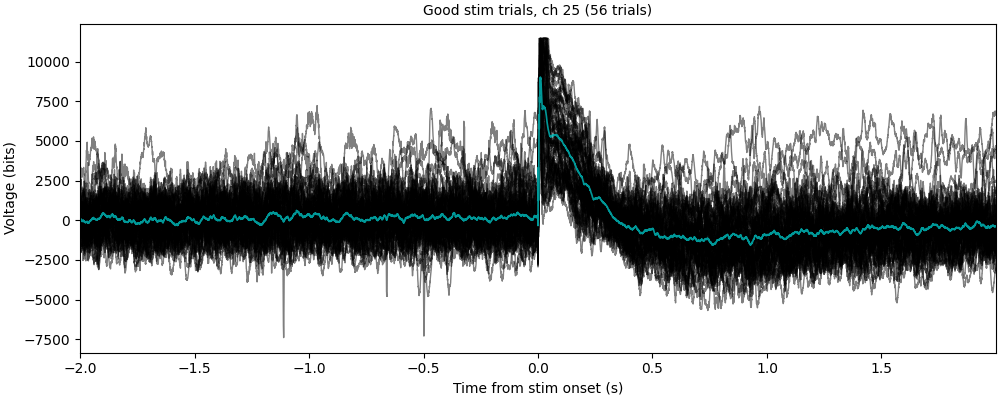

In [24]:
plot_ch = 25
fig, ax = plt.subplots(figsize=(10,4), constrained_layout=True)
ax.plot(event_ts, event_LFPchs[:, plot_ch, good_trials_mask], color='k', linewidth=1.0, alpha=0.5)
ax.plot(event_ts, np.mean(event_LFPchs[:, plot_ch, good_trials_mask], axis=1), color='c', linewidth=1.2, alpha=0.8)
ax.set_xlim([event_ts[0], event_ts[-1]])
ax.set_xlabel('Time from stim onset (s)')
ax.set_ylabel('Voltage (bits)')
ax.set_title('Good stim trials, ch {:d} ({:d} trials)'.format(plot_ch, np.sum(good_trials_mask)))

In [25]:
print(np.nonzero(~good_trials_mask)[0])
print(np.nonzero(LFP_SWD_tfa == 'a')[0])

[14 33 46 57]
[14 46 47 57]


### Choose one ch and attempt to rank amplitude

In [26]:
lfp_chs = lfp_raw_chs * exp.ephys_params[probe_name]['bit_volts']
## Apply bandpass filter (reverse, filter in 1 direction, and reverse again to correct for analog filter phase shift) ##
hardware_filter = signal.butter(1, Wn=[10, 50], btype='band', fs=exp.ephys_params[probe_name]['lfp_sample_rate']) # Wn=[0.5, 50]
lfp_chs = np.flip(signal.lfilter(*hardware_filter, np.flip(lfp_chs)))

In [27]:
event_window = [-2.0, 2.0]
plot_events = stim_log[stim_log['stim_type'] == 'biphasic']
event_LFPchs, event_ts = get_evoked_traces(
    lfp_chs, lfp_ts, plot_events.onset.values, -event_window[0], event_window[1], exp.ephys_params[probe_name]['lfp_sample_rate']
)
print(event_LFPchs.shape)

(10000, 126, 60)


Text(0.5, 1.0, 'Good stim trials, ch 60-SSp-tr5 (56 trials)')

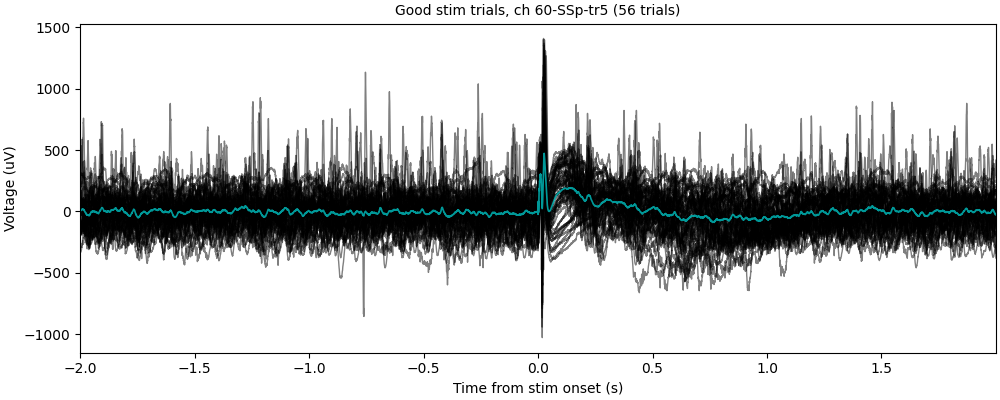

In [28]:
plot_ch = 60
fig, ax = plt.subplots(figsize=(10,4), constrained_layout=True)
ax.plot(event_ts, event_LFPchs[:, plot_ch, good_trials_mask], color='k', linewidth=1.0, alpha=0.5)
ax.plot(event_ts, np.mean(event_LFPchs[:, plot_ch, good_trials_mask], axis=1), color='c', linewidth=1.2, alpha=0.8)
ax.set_xlim([event_ts[0], event_ts[-1]])
ax.set_xlabel('Time from stim onset (s)')
ax.set_ylabel('Voltage (uV)')
ax.set_title('Good stim trials, ch {:d}-{} ({:d} trials)'.format(plot_ch, probe_areas[np.argwhere(area_mask)[plot_ch]][0], np.sum(good_trials_mask)))

Get the mean amplitude in a baseline window and the response window

In [29]:
BaselineWindow = [-0.5, -0.01]
ResponseWindow = [0.005, 0.2] # original SR [0.005, 0.1]
baselineinds = np.squeeze(np.argwhere((event_ts >= BaselineWindow[0]) & (event_ts <= BaselineWindow[1])))
responseinds = np.squeeze(np.argwhere((event_ts >= ResponseWindow[0]) & (event_ts <= ResponseWindow[1])))

Pw_Baseline = np.mean(np.abs(event_LFPchs[baselineinds, :, :]), axis=0)
Pw_Response = np.mean(np.abs(event_LFPchs[responseinds, :, :]), axis=0)
print(Pw_Response.shape)

(126, 60)


### Get the mean rank value for all SWD EPs

In [30]:
## Define which classification to use ##
# stim_in_SWDtf = EEG_SWD
# stim_in_SWDtf = LFP_SWD_tfa == 't'
stim_in_SWDtf = LFP_SWD_tf

Only non-artifact trials

In [31]:
all_ch_mean_ranks = []
for chi in range(event_LFPchs.shape[1]):
    ch_ranked_good_trials = np.argsort(Pw_Response[chi, good_trials_mask])
    trial_ranks_good = np.empty_like(ch_ranked_good_trials)
    trial_ranks_good[ch_ranked_good_trials] = np.arange(len(ch_ranked_good_trials)) + 1
    rankings_good = trial_ranks_good / np.max(trial_ranks_good)
    all_ch_mean_ranks.append(np.mean(rankings_good[stim_in_SWDtf[good_trials_mask]]))
all_ch_mean_ranks = np.array(all_ch_mean_ranks)

In [32]:
all_ch_mean_ranks

array([0.5656682 , 0.56336406, 0.56105991, 0.56221198, 0.56048387,
       0.55990783, 0.55587558, 0.55414747, 0.54781106, 0.54665899,
       0.54147465, 0.54089862, 0.53859447, 0.5328341 , 0.52764977,
       0.52592166, 0.52476959, 0.51843318, 0.51209677, 0.51152074,
       0.51209677, 0.51670507, 0.52016129, 0.52073733, 0.52131336,
       0.51843318, 0.52016129, 0.52419355, 0.52476959, 0.52534562,
       0.52592166, 0.53110599, 0.53686636, 0.53801843, 0.54320276,
       0.54665899, 0.55414747, 0.55529954, 0.55184332, 0.54953917,
       0.54089862, 0.52937788, 0.51843318, 0.51209677, 0.50748848,
       0.49711982, 0.48790323, 0.47753456, 0.47119816, 0.46370968,
       0.4562212 , 0.44412442, 0.43663594, 0.42511521, 0.41705069,
       0.41013825, 0.39976959, 0.38882488, 0.38421659, 0.37788018,
       0.37442396, 0.37269585, 0.36751152, 0.36866359, 0.36635945,
       0.36463134, 0.36808756, 0.36866359, 0.37442396, 0.37730415,
       0.38018433, 0.38306452, 0.38997696, 0.39573733, 0.40092

In [33]:
print(len(all_ch_mean_ranks))
print(np.sum(all_ch_mean_ranks < 0.5))

126
40


In [38]:
plot_ch = 50
ch_ranked_good_trials = np.argsort(Pw_Response[plot_ch, good_trials_mask])
trial_ranks_good = np.empty_like(ch_ranked_good_trials)
trial_ranks_good[ch_ranked_good_trials] = np.arange(len(ch_ranked_good_trials)) + 1
rankings_good = trial_ranks_good / np.max(trial_ranks_good)
print(len(rankings_good))
SWDmeanrank_good = np.mean(rankings_good[stim_in_SWDtf[good_trials_mask]])
print(SWDmeanrank_good)

56
0.456221198156682


In [39]:
print('Rank from EEG classification: {:.3f}'.format(np.mean(rankings_good[EEG_SWD[good_trials_mask]])))
print('Rank from LFP(tfa) classification: {:.3f}'.format(np.mean(rankings_good[(LFP_SWD_tfa == 't')[good_trials_mask]])))
print('Rank from LFP(T/F) classification: {:.3f}'.format(np.mean(rankings_good[LFP_SWD_tf[good_trials_mask]])))

Rank from EEG classification: 0.450
Rank from LFP(tfa) classification: 0.466
Rank from LFP(T/F) classification: 0.456


In [40]:
ruff = np.arange(len(ch_ranked_good_trials)) + 1
ruff_rankings = ruff / np.max(ruff)
rand_mean_rank = []
for i in range (100):
    np.random.shuffle(ruff_rankings)
    rand_mean_rank.append(np.mean(ruff_rankings[stim_in_SWDtf[good_trials_mask]]))
rand_mean_rank = np.array(rand_mean_rank)

Text(0.5, 1.0, 'Mean rank: 0.456')

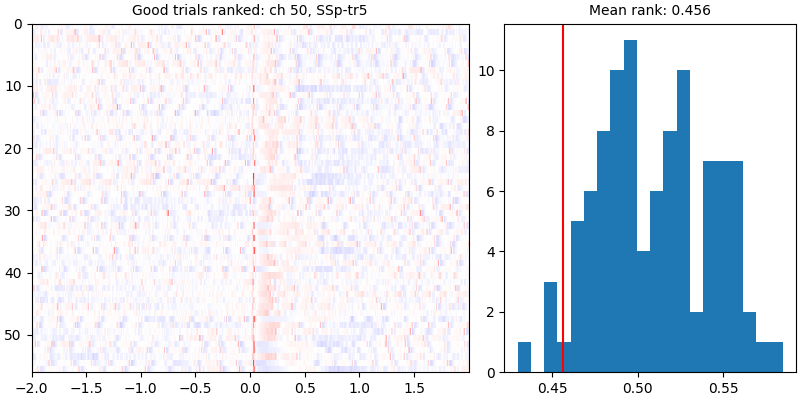

In [41]:
fig, axs = plt.subplots(1, 2, figsize=(8,4), gridspec_kw={'width_ratios': [3, 2]}, constrained_layout=True)
vlevel = 2500
ch_ranked = np.argsort(Pw_Response[plot_ch, good_trials_mask])
axs[0].imshow(
    event_LFPchs[:, plot_ch, :][:, good_trials_mask][:, ch_ranked].T, aspect='auto', interpolation='none',
    cmap='bwr', vmin=-vlevel, vmax=vlevel, extent=[event_ts[0], event_ts[-1], np.sum(good_trials_mask), 0],
)
axs[0].set_title('Good trials ranked: ch {:d}, {}'.format(plot_ch, probe_areas[np.argwhere(area_mask)[plot_ch]][0]))

axs[1].hist(rand_mean_rank, bins=20)
axs[1].axvline(SWDmeanrank_good, color='r')
axs[1].set_title('Mean rank: {:.3f}'.format(SWDmeanrank_good))

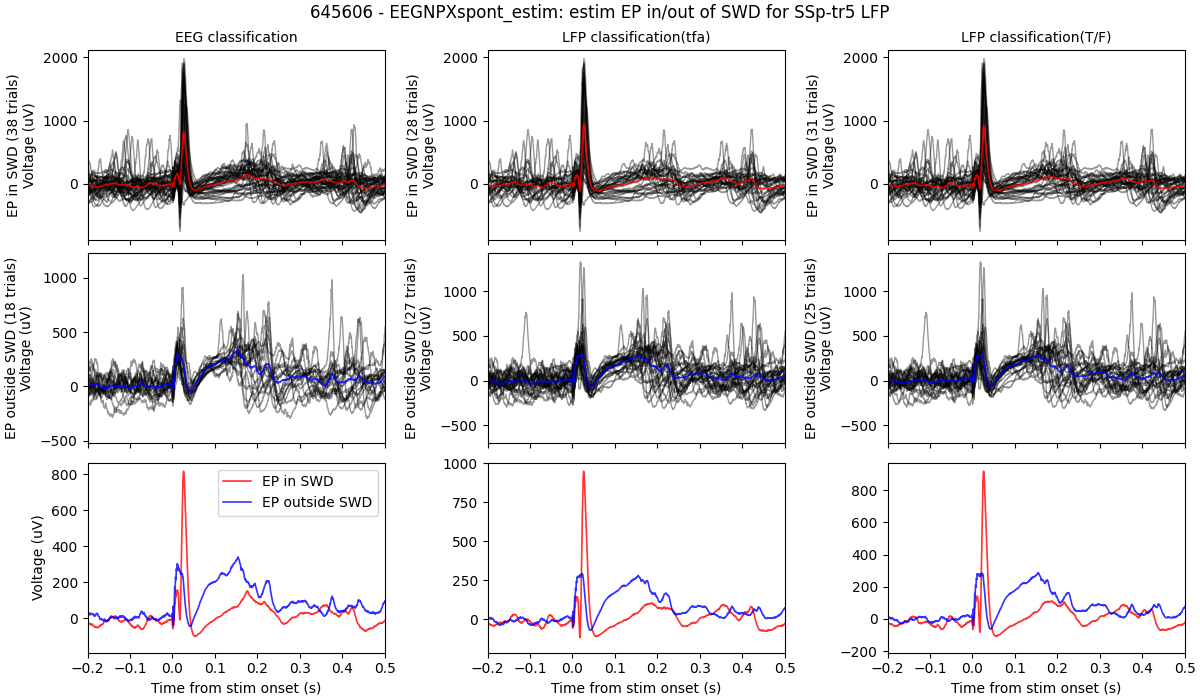

In [42]:
## ONLY GOOD TRIALS ##
# plot_ch = 75
pwin = [-0.2, 0.5]

## Plot ##
fig, axs = plt.subplots(3, 3, figsize=(12, 7), constrained_layout=True, sharex=True)
compare = {
    'EEG classification': [EEG_SWD, [True, False]],
    'LFP classification(tfa)': [LFP_SWD_tfa, ['t', 'f']],
    'LFP classification(T/F)': [LFP_SWD_tf, [True, False]]
}
for coli, (classi, tfinfo) in enumerate(compare.items()):
    axs[0, coli].set_title(classi)
    in_out_EP = []
    for ii, SWDi in enumerate(tfinfo[1]):
        mask = (tfinfo[0] == SWDi) * good_trials_mask
        event_LFPchs[:, plot_ch, mask]
        if ii == 0:
            ylab = 'EP in SWD ({:d} trials)'.format(np.sum(mask))
            pcol = 'r'
        else:
            ylab = 'EP outside SWD ({:d} trials)'.format(np.sum(mask))
            pcol = 'b'
        axs[ii, coli].plot(event_ts, event_LFPchs[:, plot_ch, mask], color='k', linewidth=1.0, alpha=0.4)
        axs[ii, coli].plot(event_ts, np.mean(event_LFPchs[:, plot_ch, mask], axis=1), color=pcol, linewidth=1.2, alpha=0.8)
        axs[ii, coli].set_ylabel(ylab + '\nVoltage (uV)')
        in_out_EP.append(np.mean(event_LFPchs[:, plot_ch, mask], axis=1))

    for ii, SWDi in enumerate(tfinfo[1]):
        if ii == 0:
            ll = 'EP in SWD'
            pcol = 'r'
        else:
            ll = 'EP outside SWD'
            pcol = 'b'
        axs[2, coli].plot(event_ts, in_out_EP[ii], color=pcol, linewidth=1.2, alpha=0.8, label=ll)
    axs[2, coli].set_xlim(pwin)
    if coli == 0:
        axs[2, coli].legend()
        axs[2, coli].set_ylabel('Voltage (uV)')
    axs[2, coli].set_xlabel('Time from stim onset (s)')
    
plt.suptitle('{} - {}: estim EP in/out of SWD for {} LFP'.format(exp.mouse, exp_tag, probe_areas[np.argwhere(area_mask)[plot_ch]][0]))

### SAVE ###
fig_name = '{}_LFP_EP_inoutSWD_goodtrials.png'.format(probe_areas[plot_ch])
# fig.savefig(os.path.join(plotsavedir, fig_name), transparent=False)

All trials

In [46]:
# plot_ch = 75
ch_ranked = np.argsort(Pw_Response[plot_ch, :])

trial_ranks = np.empty_like(ch_ranked)
trial_ranks[ch_ranked] = np.arange(len(ch_ranked)) + 1
rankings = trial_ranks / np.max(trial_ranks)
# print(rankings)

SWDmeanrank = np.mean(rankings[stim_in_SWDtf])
print(SWDmeanrank)

0.5475


In [47]:
print('Rank from EEG classification: {:.3f}'.format(np.mean(rankings[EEG_SWD])))
print('Rank from LFP(tfa) classification: {:.3f}'.format(np.mean(rankings[LFP_SWD_tfa == 't'])))
print('Rank from LFP(T/F) classification: {:.3f}'.format(np.mean(rankings[LFP_SWD_tf])))

Rank from EEG classification: 0.552
Rank from LFP(tfa) classification: 0.269
Rank from LFP(T/F) classification: 0.547


Compare to randomly shuffled trials

In [48]:
ruff = np.arange(len(ch_ranked)) + 1
ruff_rankings = ruff / np.max(ruff)
rand_mean_rank = []
for i in range (100):
    np.random.shuffle(ruff_rankings)
    rand_mean_rank.append(np.mean(ruff_rankings[stim_in_SWDtf]))
rand_mean_rank = np.array(rand_mean_rank)

Text(0.5, 1.0, 'Mean rank: 0.547')

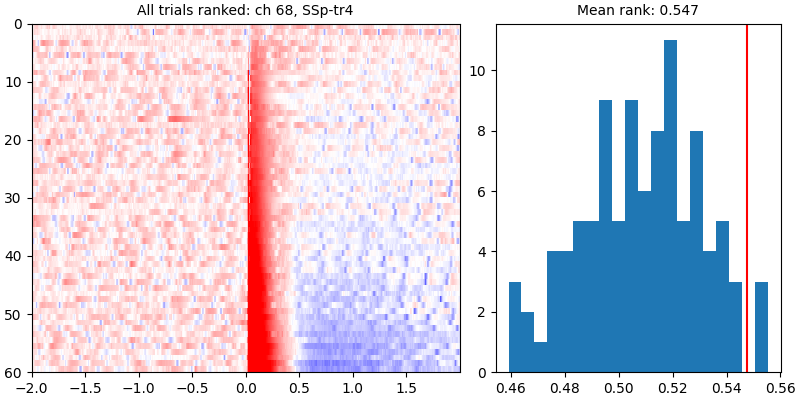

In [49]:
fig, axs = plt.subplots(1, 2, figsize=(8,4), gridspec_kw={'width_ratios': [3, 2]}, constrained_layout=True)
vlevel = 2500
ch_ranked = np.argsort(Pw_Response[plot_ch, :])
axs[0].imshow(
    event_LFPchs[:, plot_ch, ch_ranked].T, aspect='auto', interpolation='none',
    cmap='bwr', vmin=-vlevel, vmax=vlevel, extent=[event_ts[0], event_ts[-1], len(ch_ranked), 0],
)
axs[0].set_title('All trials ranked: ch {:d}, {}'.format(plot_ch, probe_areas[np.argwhere(area_mask)[plot_ch]][0]))

axs[1].hist(rand_mean_rank, bins=20)
axs[1].axvline(SWDmeanrank, color='r')
axs[1].set_title('Mean rank: {:.3f}'.format(SWDmeanrank))

#### Plot the LFP traces in/out

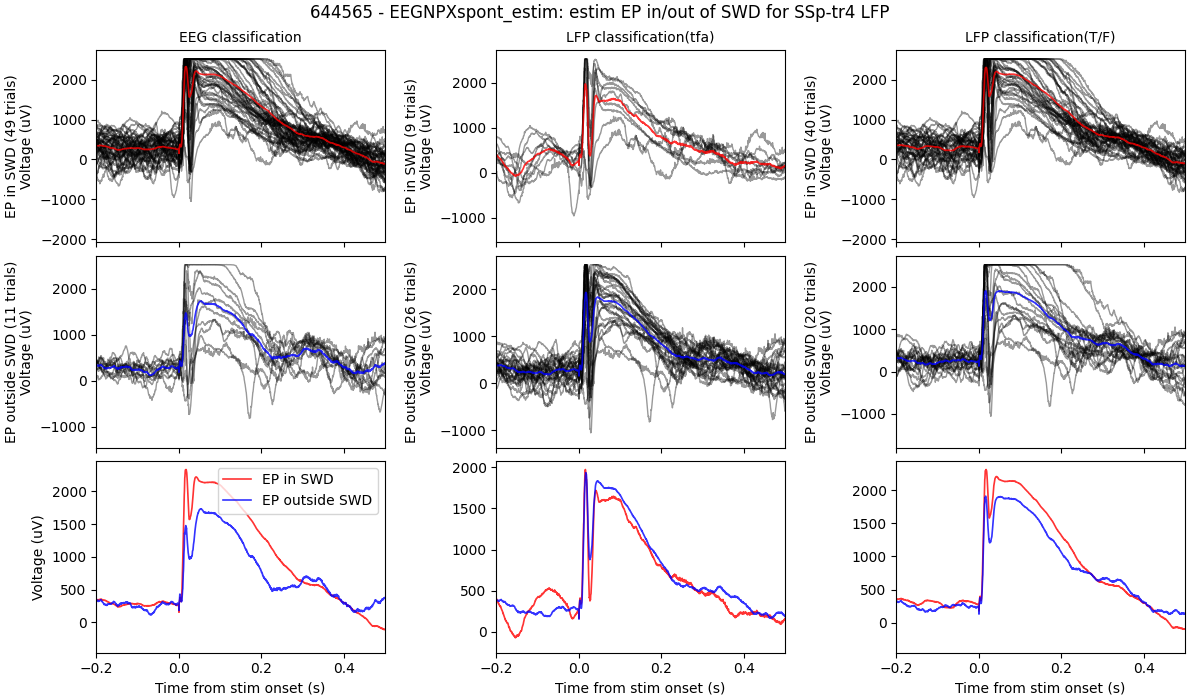

In [50]:
# plot_ch = 75
pwin = [-0.2, 0.5]

## Plot ##
fig, axs = plt.subplots(3, 3, figsize=(12, 7), constrained_layout=True, sharex=True)
compare = {
    'EEG classification': [EEG_SWD, [True, False]],
    'LFP classification(tfa)': [LFP_SWD_tfa, ['t', 'f']],
    'LFP classification(T/F)': [LFP_SWD_tf, [True, False]]
}
for coli, (classi, tfinfo) in enumerate(compare.items()):
    axs[0, coli].set_title(classi)
    in_out_EP = []
    for ii, SWDi in enumerate(tfinfo[1]):
        mask = tfinfo[0] == SWDi
        event_LFPchs[:, plot_ch, mask]
        if ii == 0:
            ylab = 'EP in SWD ({:d} trials)'.format(np.sum(mask))
            pcol = 'r'
        else:
            ylab = 'EP outside SWD ({:d} trials)'.format(np.sum(mask))
            pcol = 'b'
        axs[ii, coli].plot(event_ts, event_LFPchs[:, plot_ch, mask], color='k', linewidth=1.0, alpha=0.4)
        axs[ii, coli].plot(event_ts, np.mean(event_LFPchs[:, plot_ch, mask], axis=1), color=pcol, linewidth=1.2, alpha=0.8)
        axs[ii, coli].set_ylabel(ylab + '\nVoltage (uV)')
        in_out_EP.append(np.mean(event_LFPchs[:, plot_ch, mask], axis=1))

    for ii, SWDi in enumerate(tfinfo[1]):
        if ii == 0:
            ll = 'EP in SWD'
            pcol = 'r'
        else:
            ll = 'EP outside SWD'
            pcol = 'b'
        axs[2, coli].plot(event_ts, in_out_EP[ii], color=pcol, linewidth=1.2, alpha=0.8, label=ll)
    axs[2, coli].set_xlim(pwin)
    if coli == 0:
        axs[2, coli].legend()
        axs[2, coli].set_ylabel('Voltage (uV)')
    axs[2, coli].set_xlabel('Time from stim onset (s)')
    
plt.suptitle('{} - {}: estim EP in/out of SWD for {} LFP'.format(exp.mouse, exp_tag, probe_areas[np.argwhere(area_mask)[plot_ch]][0]))

### SAVE ###
fig_name = '{}_LFP_EP_inoutSWD.png'.format(probe_areas[plot_ch])
# fig.savefig(os.path.join(plotsavedir, fig_name), transparent=False)

## Load EEG

In [ ]:
eeg_data, eeg_ts = exp.load_eegdata()
eeg_data = eeg_data * 1E-3 # convert to mV
# eeg_chs = np.arange(0, eeg_data.shape[1])

bpb, bpa = signal.butter(3, np.array([0.5, 50])/(exp.ephys_params['EEG']['sample_rate']/2), btype='bandpass')
filt_data = signal.filtfilt(bpb, bpa, eeg_data, axis=0)

#### Get event traces from raw EEG

In [ ]:
event_window = [-2.0, 2.0]
plot_events = stim_log[stim_log['stim_type'] == 'biphasic']
raw_event_EEG, event_ts = get_evoked_traces(
    eeg_data, eeg_ts, plot_events.onset.values, -event_window[0], event_window[1], exp.ephys_params['EEG']['sample_rate']
)
print(raw_event_EEG.shape)

In [ ]:
plot_ch = 13
fig, ax = plt.subplots(figsize=(10,4), constrained_layout=True)
ax.plot(event_ts, raw_event_EEG[:, plot_ch, :], color='k', linewidth=1.0, alpha=0.5)
ax.plot(event_ts, np.mean(raw_event_EEG[:, plot_ch, :], axis=1), color='c', linewidth=1.2, alpha=0.8)
ax.set_xlim([event_ts[0], event_ts[-1]])
ax.set_xlabel('Time from stim onset (s)')
ax.set_ylabel('Voltage (bits)')
ax.set_title('All stim trials, ch {:d}'.format(plot_ch))

### Rank amplitude for all EEG chs

In [ ]:
event_window = [-2.0, 2.0]
plot_events = stim_log[stim_log['stim_type'] == 'biphasic']
filt_event_EEG, event_ts = get_evoked_traces(
    filt_data, eeg_ts, plot_events.onset.values, -event_window[0], event_window[1], exp.ephys_params['EEG']['sample_rate']
)
print(filt_event_EEG.shape)

In [ ]:
BaselineWindow = [-0.5, -0.01]
ResponseWindow = [0.005, 0.1]

baselineinds = np.squeeze(np.argwhere((event_ts >= BaselineWindow[0]) & (event_ts <= BaselineWindow[1])))
responseinds = np.squeeze(np.argwhere((event_ts >= ResponseWindow[0]) & (event_ts <= ResponseWindow[1])))

Pw_Baseline = np.mean(np.abs(filt_event_EEG[baselineinds, :, :]), axis=0)
Pw_Response = np.mean(np.abs(filt_event_EEG[responseinds, :, :]), axis=0)
print(Pw_Response.shape)

### Get the mean rank value for all SWD EPs

In [ ]:
plot_ch = 12
ch_ranked = np.argsort(Pw_Response[plot_ch, :])
print(ch_ranked)
print(len(ch_ranked))

trial_ranks = np.empty_like(ch_ranked)
trial_ranks[ch_ranked] = np.arange(len(ch_ranked)) + 1
rankings = trial_ranks / np.max(trial_ranks)
# print(rankings)

SWDmeanrank = np.mean(rankings[stim_in_SWDtf])

Compare to randomly shuffled trials

In [ ]:
ruff = np.arange(len(ch_ranked)) + 1
ruff_rankings = ruff / np.max(ruff)
rand_mean_rank = []
for i in range (100):
    np.random.shuffle(ruff_rankings)
    rand_mean_rank.append(np.mean(ruff_rankings[stim_in_SWDtf]))
rand_mean_rank = np.array(rand_mean_rank)

fig, ax = plt.subplots(figsize=(4,4), constrained_layout=True)
ax.hist(rand_mean_rank, bins=20)
ax.axvline(SWDmeanrank, color='r')
ax.set_title('All trials')

Plot the ranked trials

In [ ]:
## All trials ##
plot_ch = 10
vlevel = 1.0
ch_ranked = np.argsort(Pw_Response[plot_ch, :])
fig, ax = plt.subplots(figsize=(8,6), constrained_layout=True)
ax.imshow(
    filt_event_EEG[:, plot_ch, ch_ranked].T, aspect='auto', interpolation='none',
    cmap='bwr', vmin=-vlevel, vmax=vlevel, extent=[event_ts[0], event_ts[-1], len(ch_ranked), 0],
)

# Loop through all subs to plot all trials

In [5]:
subject_csv = Path(r"C:\Users\lesliec\OneDrive - Allen Institute\analysis\GAT1-KO_analyses\GAT1_control_NPephys_subjects.csv")
all_subexp = pd.read_csv(subject_csv, converters={'mouse': str})

## LFP

In [9]:
sub_LFP_chs = {
    '645606': 'probeB', # SSp probeB, MOp probeF
    '644565': 'probeB', # SSp probeB, MOp probeF
    '672785': 'probeD', # SSp probeD, MOp probeF
    '672789': 'probeB', # SSp probeB, MOp probeF
}

plot_area = 'SSp' # tried SSp first like SR
event_window = [-2.0, 2.0]
check_artifact_trials = True
artifact_check_window = [-0.05, 0.5]
artifact_thresh = 50
filtwin = [10, 50] # [0.5, 50]
BaselineWindow = [-0.5, -0.01]
ResponseWindow = [0.005, 0.1]
plot_ch = 70

645606: EEGNPXspont_estim_2022-12-20_12-26-39
Experiment type: electrical stimulation

644565: EEGNPXspont_estim_2022-12-22_10-36-08
Experiment type: electrical stimulation

672785: EEGNPXspont_estim_2023-07-05_12-39-59
Experiment type: electrical and sensory stimulation

672789: EEGNPXspont_estim_2023-07-13_13-28-01
Experiment type: electrical and sensory stimulation



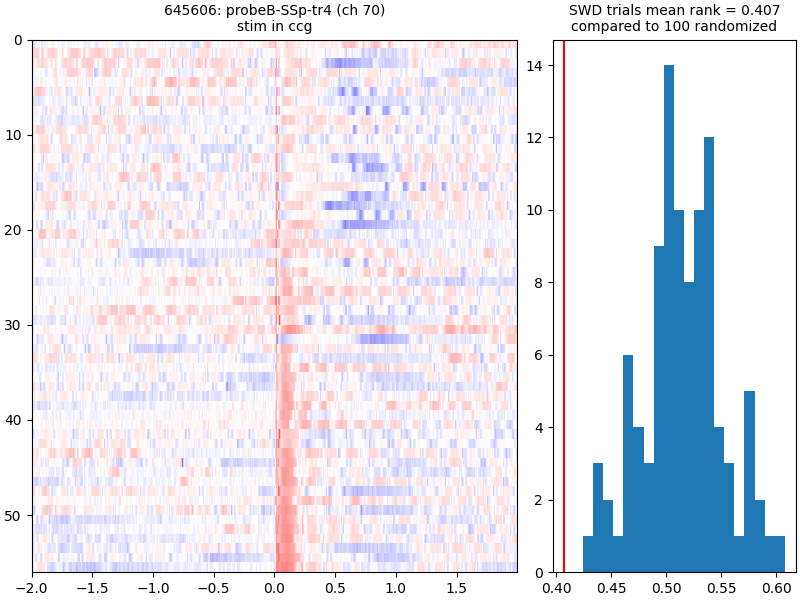

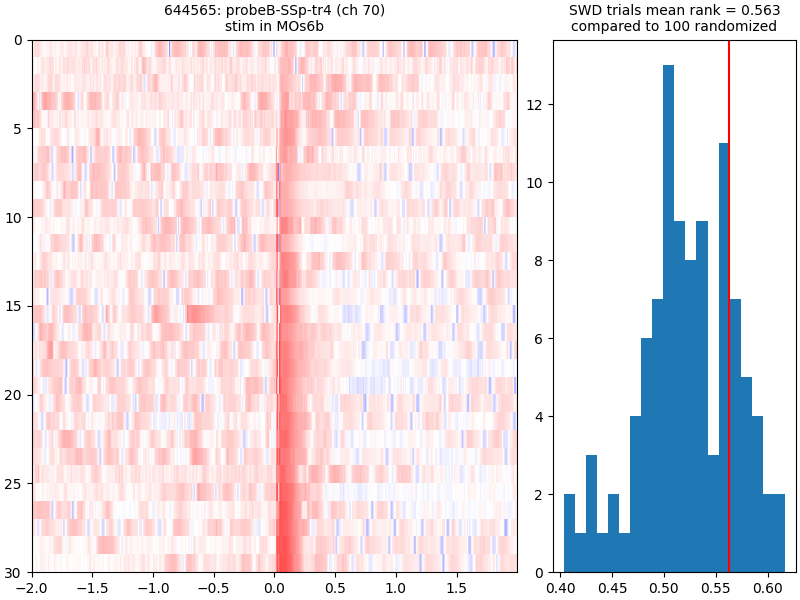

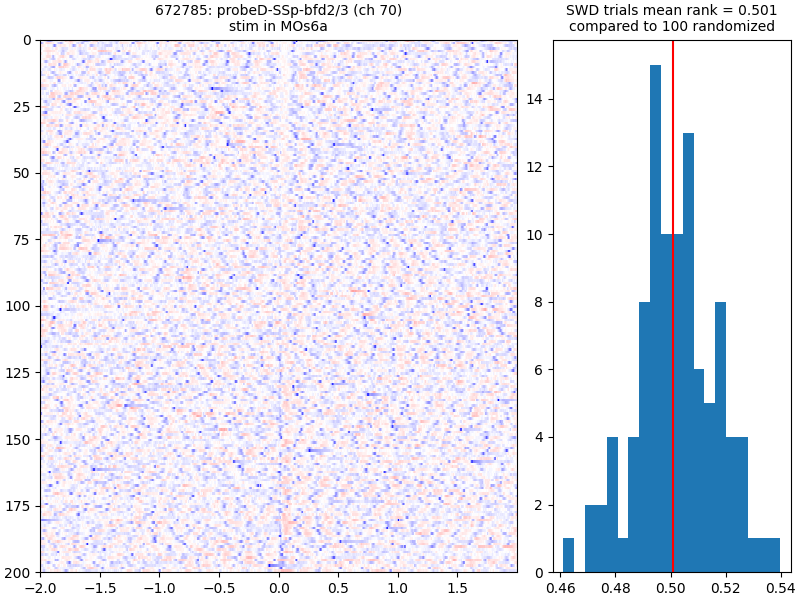

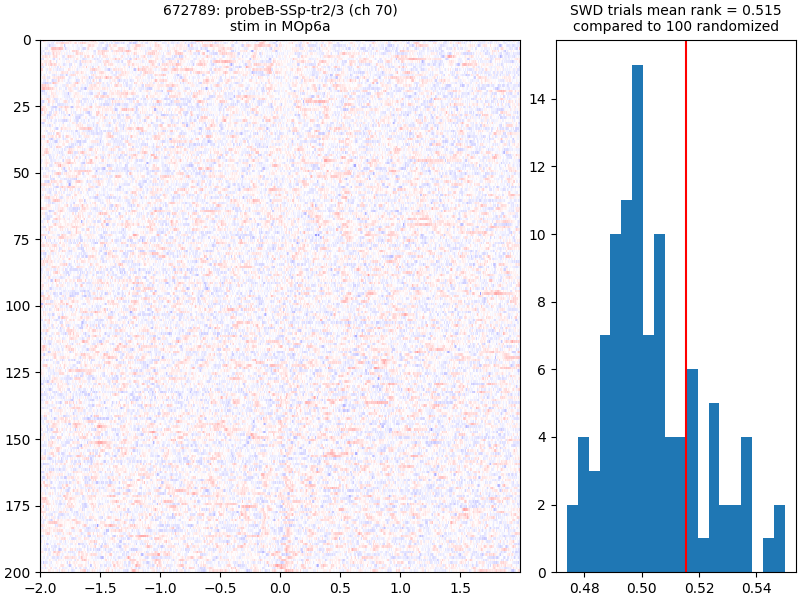

In [10]:
for rowi, exprow in all_subexp[:4].iterrows():
    print('{}: {}'.format(exprow.mouse, exprow.experiment))
    exp = EEGexp(exprow.data_loc, preprocess=False, make_stim_csv=False)
    plotsavedir = os.path.join(r'C:\Users\lesliec\OneDrive - Allen Institute\analysis\GAT1-KO_analyses', 'mouse' + exp.mouse)
    exp_tag = exp.experiment_folder[exp.experiment_folder.find('mouse')+12:exp.experiment_folder.find(str(exp.date.year))-1]
    stim_elec_file = os.path.join(exp.data_folder, r'stim_elec_location.json')
    if os.path.exists(stim_elec_file):
        with open(stim_elec_file) as elec_file:
            stim_elec_data = json.load(elec_file)
    else:
        print('Stim electrode location file not found.')
    stimSWDboolfile = os.path.join(exp.data_folder, r'EP_in_SWD_LFP_TF.npy')
    if os.path.exists(stimSWDboolfile):
        stim_in_SWDtf = np.load(stimSWDboolfile).astype(bool)
        # print(stim_in_SWD[:10])
        # stim_log['manualSWD'] = stim_in_SWD
    else:
        print('Session has no EP_in_SWD file.')

    stim_log = pd.read_csv(exp.stimulus_log_file).astype({'parameter': str})
    # probe_name = sub_LFP_chs[exprow.mouse]
    
    ## Load probe_info.json ##
    with open(exp.ephys_params[sub_LFP_chs[exprow.mouse]]['probe_info']) as data_file:
        data = json.load(data_file)
    ref_mask = np.array(data['mask'])
    probe_areas = np.array(data['area_ch'])
    area_mask = np.array([plot_area in x for x in probe_areas]) * ref_mask

    ## Load LFP as memmap ##
    lfp_ts = np.load(exp.ephys_params[sub_LFP_chs[exprow.mouse]]['lfp_timestamps'])
    lfp_data_mm = np.memmap(exp.ephys_params[sub_LFP_chs[exprow.mouse]]['lfp_continuous'], dtype='int16', mode='r').reshape(
        (len(lfp_ts), exp.ephys_params[sub_LFP_chs[exprow.mouse]]['num_chs']))
    lfp_raw_chs = lfp_data_mm[:, area_mask]
    plot_events = stim_log[stim_log['stim_type'] == 'biphasic']
    
    #### Get artifact trials ####
    if check_artifact_trials:
        event_LFPchs, event_ts = get_evoked_traces(
            lfp_raw_chs, lfp_ts, plot_events.onset.values, -event_window[0], event_window[1], exp.ephys_params[sub_LFP_chs[exprow.mouse]]['lfp_sample_rate']
        )
        checkinds = np.squeeze(np.argwhere((event_ts >= artifact_check_window[0]) & (event_ts <= artifact_check_window[1])))
        num_samples = []
        for chi, max_val in enumerate(np.max(np.max(event_LFPchs[checkinds,:,:], axis=2), axis=0)):
            num_samples.append(np.sum(event_LFPchs[checkinds,chi,:] > (max_val - 500), axis=0))
        num_samples_all_trials = np.array(num_samples)
        good_trials = np.where(np.median(num_samples_all_trials, axis=0) < artifact_thresh)[0]
        bad_trials = np.where(np.median(num_samples_all_trials, axis=0) >= artifact_thresh)[0]
        del event_LFPchs, event_ts

    #### Get the amplitude and rank for all trials ####
    lfp_chs = lfp_raw_chs * exp.ephys_params[sub_LFP_chs[exprow.mouse]]['bit_volts']
    ## Apply bandpass filter (reverse, filter in 1 direction, and reverse again to correct for analog filter phase shift) ##
    hardware_filter = signal.butter(1, Wn=filtwin, btype='band', fs=exp.ephys_params[sub_LFP_chs[exprow.mouse]]['lfp_sample_rate'])
    lfp_chs = np.flip(signal.lfilter(*hardware_filter, np.flip(lfp_chs)))
    ## Evoked signals ##
    event_LFPchs, event_ts = get_evoked_traces(
        lfp_chs, lfp_ts, plot_events.onset.values, -event_window[0], event_window[1], exp.ephys_params[sub_LFP_chs[exprow.mouse]]['lfp_sample_rate']
    )
    ## Get mean of abs of signal in baseline and response windows ##
    baselineinds = np.squeeze(np.argwhere((event_ts >= BaselineWindow[0]) & (event_ts <= BaselineWindow[1])))
    responseinds = np.squeeze(np.argwhere((event_ts >= ResponseWindow[0]) & (event_ts <= ResponseWindow[1])))
    Pw_Baseline = np.mean(np.abs(event_LFPchs[baselineinds, :, :]), axis=0)
    Pw_Response = np.mean(np.abs(event_LFPchs[responseinds, :, :]), axis=0)

    vlevel = 1500
    ch_ranked = np.argsort(Pw_Response[plot_ch, good_trials])
    ## Get mean rank for SWD trials ##
    trial_ranks = np.empty_like(ch_ranked)
    trial_ranks[ch_ranked] = np.arange(len(ch_ranked)) + 1
    rankings = trial_ranks / np.max(trial_ranks)
    SWD_mean_rank = np.mean(rankings[stim_in_SWDtf[good_trials]])
    
    ruff = np.arange(len(ch_ranked)) + 1
    ruff_rankings = ruff / np.max(ruff)
    rand_mean_rank = []
    for i in range(100):
        np.random.shuffle(ruff_rankings)
        rand_mean_rank.append(np.mean(ruff_rankings[stim_in_SWDtf[good_trials]]))
    rand_mean_rank = np.array(rand_mean_rank)
    ## Plot only good trials ##
    fig, axs = plt.subplots(1, 2, figsize=(8,6), gridspec_kw={'width_ratios': [2, 1]}, constrained_layout=True)
    axs[0].imshow(
        event_LFPchs[:, plot_ch, :][:, good_trials[ch_ranked]].T, aspect='auto', interpolation='none',
        cmap='bwr', vmin=-vlevel, vmax=vlevel, extent=[event_ts[0], event_ts[-1], len(ch_ranked), 0],
    )
    axs[0].set_title('{}: {}-{} (ch {:d})\nstim in {}'.format(exprow.mouse, sub_LFP_chs[exprow.mouse], probe_areas[np.argwhere(area_mask)[plot_ch]][0], plot_ch, stim_elec_data['tip']['area']))
    
    axs[1].hist(rand_mean_rank, bins=20)
    axs[1].axvline(SWD_mean_rank, color='r')
    axs[1].set_title('SWD trials mean rank = {:.3f}\ncompared to 100 randomized'.format(SWD_mean_rank))

    ### SAVE ###
    fig_name = '{}{}_LFP-{}ch{:d}_meanSWDranks.png'.format(exp.mouse, exp_tag, plot_area, plot_ch)
    fig.savefig(os.path.join(plotsavedir, fig_name), transparent=False)

    print('')

## EEG

In [ ]:
event_window = [-2.0, 2.0]
check_artifact_trials = False
artifact_check_window = [-0.05, 0.5]
artifact_thresh = 20
BaselineWindow = [-0.5, -0.01]
ResponseWindow = [0.005, 0.1]

In [ ]:
for rowi, exprow in all_subexp[:4].iterrows():
    print('{}: {}'.format(exprow.mouse, exprow.experiment))
    exp = EEGexp(exprow.data_loc, preprocess=False, make_stim_csv=False)
    plotsavedir = os.path.join(r'C:\Users\lesliec\OneDrive - Allen Institute\analysis\GAT1-KO_analyses', 'mouse' + exp.mouse)
    exp_tag = exp.experiment_folder[exp.experiment_folder.find('mouse')+12:exp.experiment_folder.find(str(exp.date.year))-1]
    stim_elec_file = os.path.join(exp.data_folder, r'stim_elec_location.json')
    if os.path.exists(stim_elec_file):
        with open(stim_elec_file) as elec_file:
            stim_elec_data = json.load(elec_file)
    else:
        print('Stim electrode location file not found.')
    stimSWDboolfile = os.path.join(exp.data_folder, r'EP_in_SWD_LFP_TF.npy')
    if os.path.exists(stimSWDboolfile):
        stim_in_SWDtf = np.load(stimSWDboolfile).astype(bool)
        # print(stim_in_SWD[:10])
        # stim_log['manualSWD'] = stim_in_SWD
    else:
        print('Session has no EP_in_SWD file.')

    stim_log = pd.read_csv(exp.stimulus_log_file).astype({'parameter': str})
    # probe_name = sub_LFP_chs[exprow.mouse]

    ## Load EEG data ##
    eeg_data, eeg_ts = exp.load_eegdata()
    eeg_data = eeg_data * 1E-3 # convert to mV
    # eeg_chs = np.arange(0, eeg_data.shape[1])
    # bad_chs = []
    # GOOD_CHS = np.array([x for x in eeg_chs if x not in bad_chs])
    bpb, bpa = signal.butter(3, np.array([0.5, 50])/(exp.ephys_params['EEG']['sample_rate']/2), btype='bandpass')
    filt_data = signal.filtfilt(bpb, bpa, eeg_data, axis=0)

    event_window = [-2.0, 2.0]
    plot_events = stim_log[stim_log['stim_type'] == 'biphasic']
    filt_event_EEG, event_ts = get_evoked_traces(
        filt_data, eeg_ts, plot_events.onset.values, -event_window[0], event_window[1], exp.ephys_params['EEG']['sample_rate']
    )
    
    #### Get artifact trials ####
    if check_artifact_trials:
        event_LFPchs, event_ts = get_evoked_traces(
            lfp_raw_chs, lfp_ts, plot_events.onset.values, -event_window[0], event_window[1], exp.ephys_params[sub_LFP_chs[exprow.mouse]]['lfp_sample_rate']
        )
        checkinds = np.squeeze(np.argwhere((event_ts >= artifact_check_window[0]) & (event_ts <= artifact_check_window[1])))
        num_samples = []
        for chi, max_val in enumerate(np.max(np.max(event_LFPchs[checkinds,:,:], axis=2), axis=0)):
            num_samples.append(np.sum(event_LFPchs[checkinds,chi,:] > (max_val - 500), axis=0))
        num_samples_all_trials = np.array(num_samples)
        good_trials = np.where(np.median(num_samples_all_trials, axis=0) < artifact_thresh)[0]
        bad_trials = np.where(np.median(num_samples_all_trials, axis=0) >= artifact_thresh)[0]
        del event_LFPchs, event_ts

    ## Get mean of abs of signal in baseline and response windows ##
    baselineinds = np.squeeze(np.argwhere((event_ts >= BaselineWindow[0]) & (event_ts <= BaselineWindow[1])))
    responseinds = np.squeeze(np.argwhere((event_ts >= ResponseWindow[0]) & (event_ts <= ResponseWindow[1])))
    Pw_Baseline = np.mean(np.abs(filt_event_EEG[baselineinds, :, :]), axis=0)
    Pw_Response = np.mean(np.abs(filt_event_EEG[responseinds, :, :]), axis=0)

    ## Plot all trials ##
    plot_ch = 14
    vlevel = 1.5
    ch_ranked = np.argsort(Pw_Response[plot_ch, :])
    ## Get mean rank for SWD trials ##
    trial_ranks = np.empty_like(ch_ranked)
    trial_ranks[ch_ranked] = np.arange(len(ch_ranked)) + 1
    rankings = trial_ranks / np.max(trial_ranks)
    SWD_mean_rank = np.mean(rankings[stim_in_SWDtf])
    
    ruff = np.arange(len(ch_ranked)) + 1
    ruff_rankings = ruff / np.max(ruff)
    rand_mean_rank = []
    for i in range(100):
        np.random.shuffle(ruff_rankings)
        rand_mean_rank.append(np.mean(ruff_rankings[stim_in_SWDtf]))
    rand_mean_rank = np.array(rand_mean_rank)
    ## Plot only good trials ##
    fig, axs = plt.subplots(1, 2, figsize=(8,6), gridspec_kw={'width_ratios': [2, 1]}, constrained_layout=True)
    axs[0].imshow(
        filt_event_EEG[:, plot_ch, ch_ranked].T, aspect='auto', interpolation='none',
        cmap='bwr', vmin=-vlevel, vmax=vlevel, extent=[event_ts[0], event_ts[-1], len(ch_ranked), 0],
    )
    axs[0].set_title('{}: EEG (ch {:d})\nstim in {}'.format(exprow.mouse, plot_ch, stim_elec_data['tip']['area']))
    
    axs[1].hist(rand_mean_rank, bins=20)
    axs[1].axvline(SWD_mean_rank, color='r')
    axs[1].set_title('SWD trials mean rank = {:.3f}\ncompared to 100 randomized'.format(SWD_mean_rank))

    ### SAVE ###
    fig_name = '{}{}_EEG-ch{:d}_meanSWDranks.png'.format(exp.mouse, exp_tag, plot_ch)
    fig.savefig(os.path.join(plotsavedir, fig_name), transparent=False)

    print('')